# **Brain Abnormality Classification**



**Full name: Sajede Fadaei**

**Student Number: 400211513**

In this exercise we are going to train a CNN-based model for a multi-class classification task, brain abnormality classification. The dataset we are going to use is a small imbalanced one that contains MRIs of both normal and abnormal brains.
We will learn how to use and refine models that have been already trained on some other rich datasets to deal with situations in which we don't have access to good datasets or powerful hardware.
This exercise has been broken into some smaller sections and each section has its score. What you are supposed to do is shown in `"======== TODO ========"` format. Any part which is showed by `...` should be completed. with There may be some **Questions** in the notes below. It is not necessary to answer these questions, but they will help you to do the next sections.

# Imports

First of all we need to import required libraries.

In [1]:
from __future__ import print_function
from __future__ import division
import imgaug
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from PIL import Image
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
import matplotlib.pyplot as plt
import seaborn as sns
import time
import shutil
import os
import random
import copy
import math
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  2.0.1+cu118
Torchvision Version:  0.15.2+cu118


# 1) Data Preparation:

## 1.1) Download Dataset

The following pieces of code will download dataset to your colab storage and remove corrupted or useless files.

In [2]:
!wget --content-disposition https://figshare.com/ndownloader/files/28399209
!mkdir dataset
!tar xvf NINS_Dataset.tar --directory dataset/

Streaming output truncated to the last 5000 lines.
./Brain Infection with abscess/58211497.jpg
./Brain Infection with abscess/58211513.jpg
./Brain Infection with abscess/58211529.jpg
./Brain Infection with abscess/58211545.jpg
./Brain Infection with abscess/58211561.jpg
./Brain Infection with abscess/58211577.jpg
./Brain Infection with abscess/58211593.jpg
./Brain Infection with abscess/58211609.jpg
./Brain Infection with abscess/97887252.jpg
./Brain Infection with abscess/97887268.jpg
./Brain Infection with abscess/97887284.jpg
./Brain Infection with abscess/97887300.jpg
./Brain Infection with abscess/97887316.jpg
./Brain Infection with abscess/97887332.jpg
./Brain Infection with abscess/97887348.jpg
./Brain Infection with abscess/97887364.jpg
./Brain Infection with abscess/97887380.jpg
./Brain Infection with abscess/97887396.jpg
./Brain Infection with abscess/97887412.jpg
./Brain Infection with abscess/97887428.jpg
./Brain Infection with abscess/97887444.jpg
./Brain Infection with ab

In [3]:
# Set the directory containing the images
data_dir = 'dataset/'

classes = os.listdir(data_dir)
shutil.rmtree(os.path.join(data_dir, 'models'))
classes = os.listdir(data_dir)

for c in classes:
    images = os.listdir(os.path.join(data_dir, c))
    for image in images:
      if image[-4:] != '.jpg':
        corrupted_img = os.path.join(data_dir, c, image)
        try:
          os.remove(corrupted_img)
        except:
          shutil.rmtree(corrupted_img)

## 1.2) Splitting Dataset: 5

The data should be spilitted into three groups: train, validation, and test. The groups' size are your choice and they should be reasonable, but it is recommended to use 0.8, 0.1, and 0.1 for train, validation, and test, respectively.

In [4]:
# Set up directories and data splits
root_dir = 'dataset'
classes = os.listdir(root_dir)

############## To Do ##############
train_split = 0.8
val_split = 0.1
test_split = 0.1
###################################

# Create a dictionary with images and labels
data_dict = {}
for idx, class_name in enumerate(classes):
    class_dir = os.path.join(root_dir, class_name)
    data_dict[class_name] = [os.path.join(class_dir, img) for img in os.listdir(class_dir)]
# print(data_dict)
############## To Do ##############
# Create train, validation and test splits
# Also print the number of samples in each class
train_images = []
val_images = []
test_images = []
sizes = []
for cls_name, images in data_dict.items():
    random.shuffle(images)
    size = len(images)
    sizes.append(size)
    print(f"{cls_name} size: {size}")
    idx_80 = int(size * train_split)
    idx_90 = int(size * (train_split + val_split))
    train_images.extend(images[:idx_80])
    val_images.extend(images[idx_80:idx_90])
    test_images.extend(images[idx_90:])
###################################

demyelinating lesions size: 38
small meningioma size: 36
Cerebral abscess size: 36
cerebral venous sinus thrombosis size: 76
Brain tumor (Astrocytoma Ganglioglioma) size: 38
meningioma size: 76
Small Vessel Diease Demyelination size: 38
Stroke (Haemorrhage) size: 564
NMOSD  ADEM size: 36
focal pachymeningitis size: 36
Left Retro-orbital Haemangioma size: 112
Ischemic change  demyelinating plaque size: 38
Brain tumor - Recurrenceremnant of previous lesion size: 114
Brain Atrophy size: 264
Glioma size: 76
Encephalomalacia with gliotic change size: 76
Mid triventricular hydrocephalus size: 38
Hemorrhagic collection size: 38
Post-operative Status with Small Hemorrhage size: 38
Postoperative encephalomalacia size: 38
Brain Tumor (Ependymoma) size: 36
Stroke (Demyelination) size: 38
Brain Tumor size: 76
Brain Infection size: 38
Malformation (Chiari I) size: 38
Stroke(infarct) size: 906
Brain tumor (Dermoid cyst craniopharyngioma) size: 38
Brain Tumor (Hemangioblastoma  Pleomorphic xanthroast

**Question:** How many classes are there in your dataset?

**Question:** Did you notice the imbalance between classes?

We put samples of each group in a seperate folder.

In [5]:
!mkdir train val test

n_img = 0
for image in train_images:
  n_img += 1
  os.makedirs(os.path.join('train', image.split('/')[1]), exist_ok=True)
  shutil.copy(image, os.path.join('train', *image.split('/')[1:]))

for image in val_images:
  os.makedirs(os.path.join('val', image.split('/')[1]), exist_ok=True)
  shutil.copy(image, os.path.join('val', *image.split('/')[1:]))

for image in test_images:
  os.makedirs(os.path.join('test', image.split('/')[1]), exist_ok=True)
  shutil.copy(image, os.path.join('test', *image.split('/')[1:]))

## 1.3) Calculate Weights of Calsses: 5

As you saw there exists an imbalance between classes. The dataset contains a class with more than a thousand samples and classes with fewer than 50 samples.

Here we want to calculate coefficients (weights) that can compensate this gap. So you are supposed to calculate these coefficients for each class such that if you multiply a class size by its corresponding coefficient the result will be equal for all the other classes. The minimum value of a coefficient should be 1.

In [6]:
############## To Do ##############
wgts = []
max_size = max(sizes)
for c in classes:
  print(c)
  size_class = len(data_dict[c])
  weight = max_size / size_class
  wgts.append(weight)
  print(f"Size of Class: {size_class}")
  print(f"Weight of Class: {weight}")
  print()

wgts = torch.Tensor(wgts)
###################################

demyelinating lesions
Size of Class: 38
Weight of Class: 46.026315789473685

small meningioma
Size of Class: 36
Weight of Class: 48.583333333333336

Cerebral abscess
Size of Class: 36
Weight of Class: 48.583333333333336

cerebral venous sinus thrombosis
Size of Class: 76
Weight of Class: 23.013157894736842

Brain tumor (Astrocytoma Ganglioglioma)
Size of Class: 38
Weight of Class: 46.026315789473685

meningioma
Size of Class: 76
Weight of Class: 23.013157894736842

Small Vessel Diease Demyelination
Size of Class: 38
Weight of Class: 46.026315789473685

Stroke (Haemorrhage)
Size of Class: 564
Weight of Class: 3.101063829787234

NMOSD  ADEM
Size of Class: 36
Weight of Class: 48.583333333333336

focal pachymeningitis
Size of Class: 36
Weight of Class: 48.583333333333336

Left Retro-orbital Haemangioma
Size of Class: 112
Weight of Class: 15.616071428571429

Ischemic change  demyelinating plaque
Size of Class: 38
Weight of Class: 46.026315789473685

Brain tumor - Recurrenceremnant of previo

## 1.4) Create DataLoaders: 5

We read and put the data of each group in its corresponding list.

In [7]:
train_images = []
train_aug_images = []
val_images = []
test_images = []

for c in classes:
    class_dir = os.path.join('train', c)
    train_images += [os.path.join(class_dir, img) for img in os.listdir(class_dir)]

    class_dir = os.path.join('val', c)
    val_images += [os.path.join(class_dir, img) for img in os.listdir(class_dir)]

    class_dir = os.path.join('test', c)
    test_images += [os.path.join(class_dir, img) for img in os.listdir(class_dir)]

print(len(train_images))

4207


Define required transforms and create Dataloaders.

**Question:** What is the approperiate input size of models like ResNet, VGG, etc.? Becarefull about the size of your images as well.

**Notice:** Select a suitable batch size.

**Notice:** Becarefull about the range of input values. They should be in [0, 1).

In [8]:
# Define a custom dataset class
class CustomDataset(Dataset):
    def __init__(self, image_list, classes=None, transform=None):
        self.image_list = image_list
        self.transform = transform
        self.label_encoder = {c: i for (i, c) in enumerate(classes)}

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, index):
        image = Image.open(self.image_list[index])

        if self.transform is not None:
            image = self.transform(image)

        label = self.image_list[index].split('/')[-2]
        label = self.label_encoder[label]

        return image, label


############## To Do ##############

# Define the transformations to be applied on the train and validation sets
transforms = torchvision.transforms.Compose([torchvision.transforms.Resize((200,200)),
                                                      torchvision.transforms.ToTensor(),
                                                      torchvision.transforms.Normalize(mean = (0.5, 0.5, 0.5),
                                                                                       std = (0.5, 0.5, 0.5))])

# Create datasets using defined CustomDataset class
train_dataset = CustomDataset(train_images, classes=classes, transform=transforms)
val_dataset = CustomDataset(val_images, classes=classes, transform=transforms)
test_dataset = CustomDataset(test_images, classes=classes, transform=transforms)

# Create dataloaders
batch_size = 5
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
print(len(test_loader))
print(len(train_loader))
print(len(val_loader))
###################################

109
842
108


In [9]:
data_loaders = {'train': train_loader, 'val': val_loader}
num_cls = len(classes) # Number of classes

## 1.2) Data Visualization

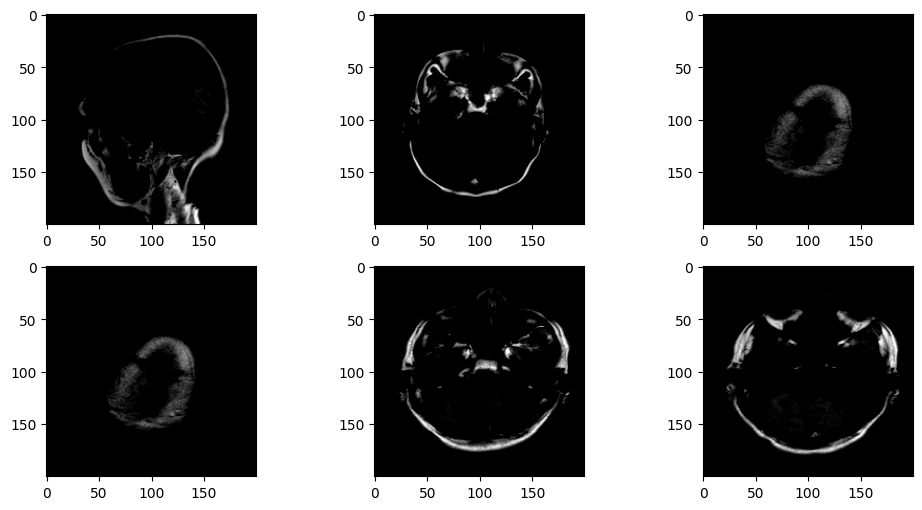

In [10]:
fig, axis = plt.subplots(2, 3, figsize=(12, 6))
for i, batch in enumerate(train_loader):
  axis[0, 0].imshow(np.array(batch[0][0]).transpose(1, 2, 0))
  axis[0, 1].imshow(np.array(batch[0][1]).transpose(1, 2, 0))
  axis[0, 2].imshow(np.array(batch[0][2]).transpose(1, 2, 0))
  axis[1, 0].imshow(np.array(batch[0][-3]).transpose(1, 2, 0),)
  axis[1, 1].imshow(np.array(batch[0][-2]).transpose(1, 2, 0),)
  axis[1, 2].imshow(np.array(batch[0][-1]).transpose(1, 2, 0),)
  break

# 2) Model Initialization and Structure Modification


## 2.1) ResNet50: 10

Load ResNet50 model with its pretrained weights. (Suggestion: IMAGENET1K_V2)

In [11]:
############## To Do ##############
resnet_model = torchvision.models.resnet50(pretrained=True)
###################################

# Print the structure of the loaded model
print(resnet_model)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 136MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

**Question:** Which part of this model is mainly used for classification? What kind of layer(s) are in this part? How many outputs does this model have? Why

Modify the classification part of the model so that it become suitable for your classification task, i.e. the number of outputs of the model becomes equal to number of classes in your dataset.

In [12]:
############## To Do ##############
num_features = resnet_model.fc.in_features
resnet_model.fc = nn.Linear(num_features, num_cls)
###################################

# Print the structure of the modified model and notice the difference
print(resnet_model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [13]:
# Specify the device (Suggestion: GPU is by far better than CPU)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnet_model = resnet_model.to(device)

## 2.2) VGG16: 10

Load VGG16 model with its pretrained parameters. (Suggestion: IMAGENET1K_V1)

In [14]:
############## To Do ##############
vgg_model = torchvision.models.vgg16(pretrained=True)
###################################

# Print the structure of the loaded model
print(vgg_model)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 147MB/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

**Question:** Which part of this model is mainly used for classification? What kind of layer(s) are in this part? How many outputs does this model have? Why

Modify the classification part of the model so that it become suitable for your classification task, i.e. the number of outputs of the model becomes equal to number of classes in your dataset.

In [15]:
############## To Do ##############
num_features = vgg_model.classifier[-1].in_features
vgg_model.classifier[-1] = nn.Linear(num_features, num_cls)
###################################

# Print the structure of the modified model and notice the difference
print(vgg_model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [16]:
# Specify the device (Suggestion: GPU is by far better than CPU)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
vgg_model = vgg_model.to(device)

# 3) Train Function: 15

Define your loss function for multi class classification. Don't forget to add class weights to it.

In [17]:
wgts = wgts.to(device)

############## To Do ##############
class_weights = wgts.to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)
###################################

Here you should define your main train function.

**Note1:** Since you are going to change the data during the training procedure, your train function have to get dataloaders as input.

**Note2:** Also you don't know how many epochs you should train.
  So save the best weights according to validation loss at the end of each epoch,
  and after the end of training, load the best model.

**Note3:** Save loss and accuracy of train and validation in each epoch to plot them later.

**Note4:** The following code is an template that can help you, but any other functions that you define with the desired properties is acceptable.


In [18]:
############## To Do ##############
def train_model(model, dataloaders, criterion, optimizer, scheduler=None, num_epochs=10):
    since = time.time()

    acc_hist = { 'train': [], 'val': [] }
    loss_hist = { 'train': [], 'val': [] }

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train() # Set model to training mode
            else:
                model.eval() # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad() # zero the parameter gradients

                # forward
                with torch.set_grad_enabled(phase == 'train'):
                    # Calculate outputs, predictions, and losses
                    outputs = model(inputs)           # Calculate outputs
                    _, preds = torch.max(outputs, 1)  # Get predictions
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0) # Summation of losses
                running_corrects += torch.sum(preds == labels.data) # Summation of true classifications

            epoch_loss = running_loss / len(dataloaders[phase].dataset) # Average of losses. Use running_loss
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset) # Accuracy. Use running_corrects

            if phase == 'val' and not(scheduler is None):
                scheduler.step(epoch_loss) # Set scheduler

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

            acc_hist[phase].append(epoch_acc)
            loss_hist[phase].append(epoch_loss)

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights with the stored state dictionary
    model.load_state_dict(best_model_wts)

    return model, acc_hist, loss_hist
###################################

# 4) Feature Extraction


In this section with just update parameters of the recently modified layer(s).

### 4.1) ResNet50

### 4.1.1) Freezing: 5

You should freeze all the parameters of the model except those of the new layer(s) you have just added.

**Help:** You can use `requires_grad` feature in Pytorch.

In [19]:
############## To Do ##############
for name, param in resnet_model.named_parameters():
    if name.startswith('fc'):
        # Unfreeze
        param.requires_grad = True
    else:
        # Freeze
        param.requires_grad = False
###################################

### 4.1.2) Training: 5

Set optimizer such that just the parameters of the new layer(s) be updateded.

**Becareful:** Learning rate is a critical hyper parameter in this training task.

Scheduler is optional.

In [20]:
############## To Do ##############
resnet_optimizer = torch.optim.SGD(
    filter(lambda p: p.requires_grad, resnet_model.parameters()),
    lr=0.001, momentum=0.9)
###################################

lr_scheduler = None

In [21]:
############## To Do ##############
resnet_fe, resnet_acc_fe, resnet_loss_fe = train_model(resnet_model, data_loaders,
                                                       criterion, resnet_optimizer,
                                                       lr_scheduler)
###################################

Epoch 0/9
----------
train Loss: 3.7987 Acc: 0.0944
val Loss: 3.1231 Acc: 0.1231

Epoch 1/9
----------
train Loss: 3.2555 Acc: 0.1443
val Loss: 2.4947 Acc: 0.3209

Epoch 2/9
----------
train Loss: 2.8711 Acc: 0.1845
val Loss: 2.6884 Acc: 0.1679

Epoch 3/9
----------
train Loss: 2.6062 Acc: 0.2051
val Loss: 2.3133 Acc: 0.2854

Epoch 4/9
----------
train Loss: 2.4119 Acc: 0.2501
val Loss: 2.5656 Acc: 0.2500

Epoch 5/9
----------
train Loss: 2.3107 Acc: 0.2598
val Loss: 3.0418 Acc: 0.2146

Epoch 6/9
----------
train Loss: 2.1737 Acc: 0.2795
val Loss: 2.7721 Acc: 0.2425

Epoch 7/9
----------
train Loss: 2.0464 Acc: 0.2843
val Loss: 1.9614 Acc: 0.4384

Epoch 8/9
----------
train Loss: 2.0043 Acc: 0.2931
val Loss: 2.6517 Acc: 0.2444

Epoch 9/9
----------
train Loss: 1.8787 Acc: 0.3121
val Loss: 2.2666 Acc: 0.3563

Training complete in 5m 43s
Best val Acc: 0.438433


### 4.2) VGG16

### 4.2.1) Freezing: 5

You should freeze all the parameters of the model except those of the new layer(s) you have just added.

**Help:** You can use `requires_grad` feature in Pytorch.

In [22]:
############## To Do ##############
for name, param in vgg_model.named_parameters():
    if name.startswith('classifier.6'):
        # Unfreeze
        param.requires_grad = True
    else:
        # Freeze
        param.requires_grad = False
###################################

### 4.2.2) Training: 5

Set optimizer such that just the parameters of the new layer(s) be updateded.

**Becareful:** Learning rate is a critical hyper parameter in this training task.

Scheduler is optional.

In [23]:
############## To Do ##############
vgg_optimizer = torch.optim.SGD(
    filter(lambda p: p.requires_grad, vgg_model.parameters()),
    lr=0.001, momentum=0.9)
###################################

lr_scheduler = None

In [24]:
############## To Do ##############
vgg_fe, vgg_acc_fe, vgg_loss_fe = train_model(vgg_model, data_loaders, criterion,
                                              vgg_optimizer, lr_scheduler)
###################################

Epoch 0/9
----------
train Loss: 5.1834 Acc: 0.0780
val Loss: 4.1574 Acc: 0.0616

Epoch 1/9
----------
train Loss: 5.2563 Acc: 0.1143
val Loss: 3.7940 Acc: 0.2276

Epoch 2/9
----------
train Loss: 5.4596 Acc: 0.1288
val Loss: 3.7363 Acc: 0.2164

Epoch 3/9
----------
train Loss: 5.3477 Acc: 0.1443
val Loss: 4.7676 Acc: 0.1213

Epoch 4/9
----------
train Loss: 5.5522 Acc: 0.1333
val Loss: 5.1426 Acc: 0.1325

Epoch 5/9
----------
train Loss: 5.4073 Acc: 0.1600
val Loss: 4.0589 Acc: 0.1343

Epoch 6/9
----------
train Loss: 5.2860 Acc: 0.1612
val Loss: 3.3496 Acc: 0.2537

Epoch 7/9
----------
train Loss: 5.2775 Acc: 0.1745
val Loss: 6.8228 Acc: 0.1157

Epoch 8/9
----------
train Loss: 5.3884 Acc: 0.1757
val Loss: 3.9035 Acc: 0.1940

Epoch 9/9
----------
train Loss: 5.3154 Acc: 0.1826
val Loss: 4.7535 Acc: 0.1455

Training complete in 7m 46s
Best val Acc: 0.253731


# 5) Fine-Tuning


In this section the whole parameters of the model are going to be updated.

## 5.1) ResNet50

### 5.1.1) Unfreezing

Unfreeze all the parameters.

In [25]:
############## To Do ##############
for param in resnet_model.parameters():
    param.requires_grad = True
###################################

### 5.1.2) Train the Model: 5

Set optimizer such that all the parameters of the model be updateded.

**Becareful:** Since we are fine-tuning the model, we expect slight changes in the parameters, so learning rate should be very small in this section. You can also define different learning rates for newly modified layer(s) and the rest of the model.

Scheduler is optional.

In [26]:
############## To Do ##############
resnet_optimizer = torch.optim.SGD(
    filter(lambda p: p.requires_grad, resnet_model.parameters()),
    lr=0.0001, momentum=0.9)


lr_scheduler = None

resnet_ft, resnet_acc_ft, resnet_loss_ft = train_model(resnet_model, data_loaders
                                                       , criterion, resnet_optimizer,
                                                       lr_scheduler)
###################################

Epoch 0/9
----------
train Loss: 1.8900 Acc: 0.3321
val Loss: 1.9094 Acc: 0.3843

Epoch 1/9
----------
train Loss: 0.8978 Acc: 0.5431
val Loss: 1.3269 Acc: 0.5280

Epoch 2/9
----------
train Loss: 0.5612 Acc: 0.6765
val Loss: 1.2404 Acc: 0.5634

Epoch 3/9
----------
train Loss: 0.3423 Acc: 0.7614
val Loss: 0.9544 Acc: 0.6810

Epoch 4/9
----------
train Loss: 0.2503 Acc: 0.8165
val Loss: 0.8606 Acc: 0.6959

Epoch 5/9
----------
train Loss: 0.1908 Acc: 0.8526
val Loss: 0.7736 Acc: 0.7500

Epoch 6/9
----------
train Loss: 0.1644 Acc: 0.8892
val Loss: 0.6710 Acc: 0.7743

Epoch 7/9
----------
train Loss: 0.1223 Acc: 0.9094
val Loss: 0.6058 Acc: 0.8153

Epoch 8/9
----------
train Loss: 0.1044 Acc: 0.9261
val Loss: 0.6177 Acc: 0.8041

Epoch 9/9
----------
train Loss: 0.1053 Acc: 0.9311
val Loss: 0.5641 Acc: 0.8172

Training complete in 10m 10s
Best val Acc: 0.817164


## 5.2) VGG16

### 5.2.1) Unfreezing

Unfreeze all the parameters.

In [27]:
############## To Do ##############
for param in vgg_model.parameters():
    param.requires_grad = True
###################################

### 5.2.2) Train the Model: 5

Set optimizer such that all the parameters of the model be updateded.

**Becareful:** Since we are fine-tuning the model, we expect slight changes in the parameters, so learning rate should be very small in this section. You can also define different learning rates for newly modified layer(s) and the rest of the model.

Scheduler is optional.

In [28]:
############## To Do ##############
vgg_optimizer = torch.optim.SGD(
    filter(lambda p: p.requires_grad, vgg_model.parameters()),
    lr=0.0001, momentum=0.9)

lr_schedular = None

vgg_ft, vgg_acc_ft, vgg_loss_ft = train_model(vgg_model, data_loaders, criterion,
                                              vgg_optimizer, lr_scheduler)
###################################

Epoch 0/9
----------
train Loss: 3.2510 Acc: 0.1367
val Loss: 2.7786 Acc: 0.1884

Epoch 1/9
----------
train Loss: 2.2463 Acc: 0.2301
val Loss: 2.0171 Acc: 0.3358

Epoch 2/9
----------
train Loss: 1.6762 Acc: 0.3299
val Loss: 1.9466 Acc: 0.3563

Epoch 3/9
----------
train Loss: 1.2235 Acc: 0.4160
val Loss: 1.7698 Acc: 0.4179

Epoch 4/9
----------
train Loss: 0.8790 Acc: 0.5034
val Loss: 1.5699 Acc: 0.4720

Epoch 5/9
----------
train Loss: 0.6939 Acc: 0.5610
val Loss: 1.1188 Acc: 0.5933

Epoch 6/9
----------
train Loss: 0.5391 Acc: 0.6349
val Loss: 1.2167 Acc: 0.5690

Epoch 7/9
----------
train Loss: 0.4684 Acc: 0.6839
val Loss: 1.0440 Acc: 0.6493

Epoch 8/9
----------
train Loss: 0.3709 Acc: 0.7278
val Loss: 1.0706 Acc: 0.6343

Epoch 9/9
----------
train Loss: 0.3518 Acc: 0.7373
val Loss: 1.0348 Acc: 0.6623

Training complete in 17m 32s
Best val Acc: 0.662313


## 6) Plot Learning Curves: 5

Put the results of feature extraction and fine-tuning together and plot 2 figures for each of the models: accuracy and loss against epochs, i.e. 4 figures at all. Plot validation and train in one figure. Plot a vertical line that distinguish between feature extraction and fine-tuning epochs.

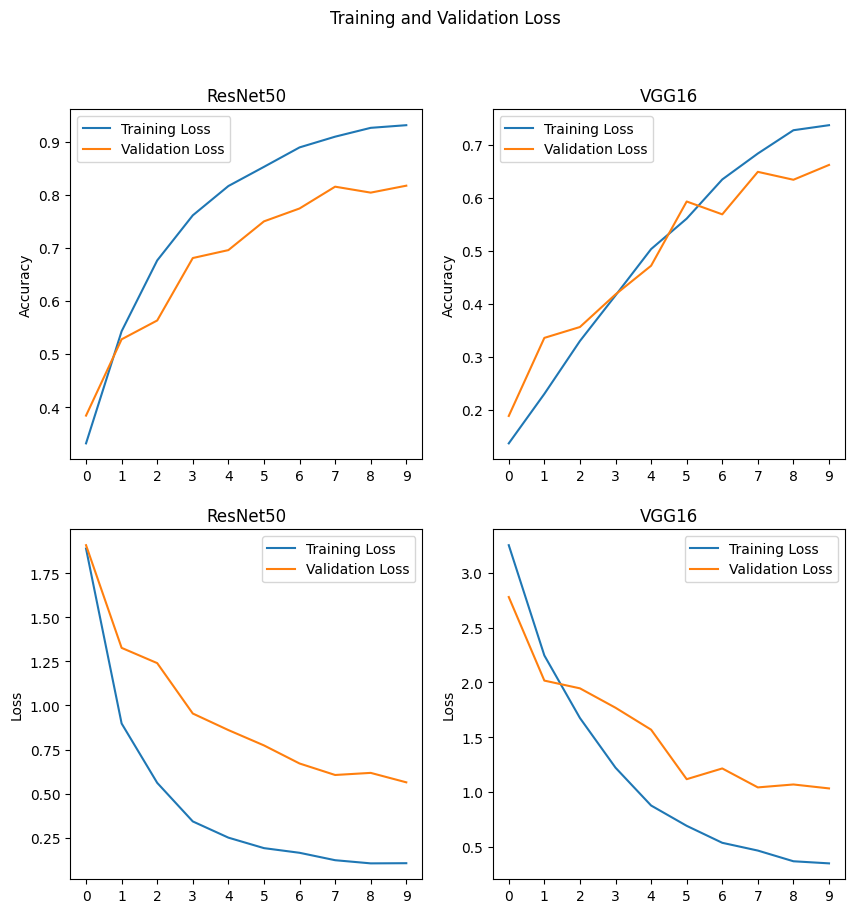

In [32]:
############## To Do ##############
# Concatenate accuracy and loss histories for ResNet50
resnet_acc = resnet_acc_fe.copy()
resnet_acc.update(resnet_acc_ft)

res_acc_metrics_cpu = {key: [val.cpu() for val in values] for key, values in resnet_acc.items()}
resnet_acc = np.array([np.array(res_acc_metrics_cpu['train']), np.array(res_acc_metrics_cpu['val'])])

resnet_loss = resnet_loss_fe.copy()
resnet_loss.update(resnet_loss_ft)
resnet_loss = np.array([np.array(resnet_loss['train']), np.array(resnet_loss['val'])])


vgg_acc = vgg_acc_ft.copy()
vgg_acc.update(vgg_acc_ft)

vgg_acc_metrics_cpu = {key: [val.cpu() for val in values] for key, values in vgg_acc.items()}
vgg_acc = np.array([np.array(vgg_acc_metrics_cpu['train']), np.array(vgg_acc_metrics_cpu['val'])])

vgg_loss = vgg_loss_ft.copy()
vgg_loss.update(vgg_loss_ft)
vgg_loss = np.array([np.array(vgg_loss['train']), np.array(vgg_loss['val'])])

# Plot accuracy and loss vs epochs for each model
epochs = range(0,10)
fig, axs = plt.subplots(2,2, figsize=(10, 10))
fig.suptitle('Training and Validation Loss')

axs[0, 0].plot(epochs, resnet_acc[0], label="Training Loss")
axs[0, 0].plot(epochs, resnet_acc[1], label= "Validation Loss")
axs[0, 0].set_title('ResNet50')
axs[0, 0].set(ylabel='Accuracy')
axs[0, 0].set_xticks(np.arange(0, 10, 1))
axs[0, 0].legend()

axs[0, 1].plot(epochs, vgg_acc[0], label="Training Loss")
axs[0, 1].plot(epochs, vgg_acc[1], label= "Validation Loss")
axs[0, 1].set_title('VGG16')
axs[0, 1].set(ylabel='Accuracy')
axs[0, 1].set_xticks(np.arange(0, 10, 1))
axs[0, 1].legend()

axs[1, 0].plot(epochs, resnet_loss[0], label="Training Loss")
axs[1, 0].plot(epochs, resnet_loss[1], label= "Validation Loss")
axs[1, 0].set_title('ResNet50')
axs[1, 0].set(ylabel='Loss')
axs[1, 0].set_xticks(np.arange(0, 10, 1))
axs[1, 0].legend()

axs[1, 1].plot(epochs, vgg_loss[0], label="Training Loss")
axs[1, 1].plot(epochs, vgg_loss[1], label= "Validation Loss")
axs[1, 1].set_title('VGG16')
axs[1, 1].set(ylabel='Loss')
axs[1, 1].set_xticks(np.arange(0, 10, 1))
axs[1, 1].legend()

## 7) Confusion Matrix: 5

Plot confusion matrix for each of the models. It should be a `num_of_classes * num_of_classes` square.

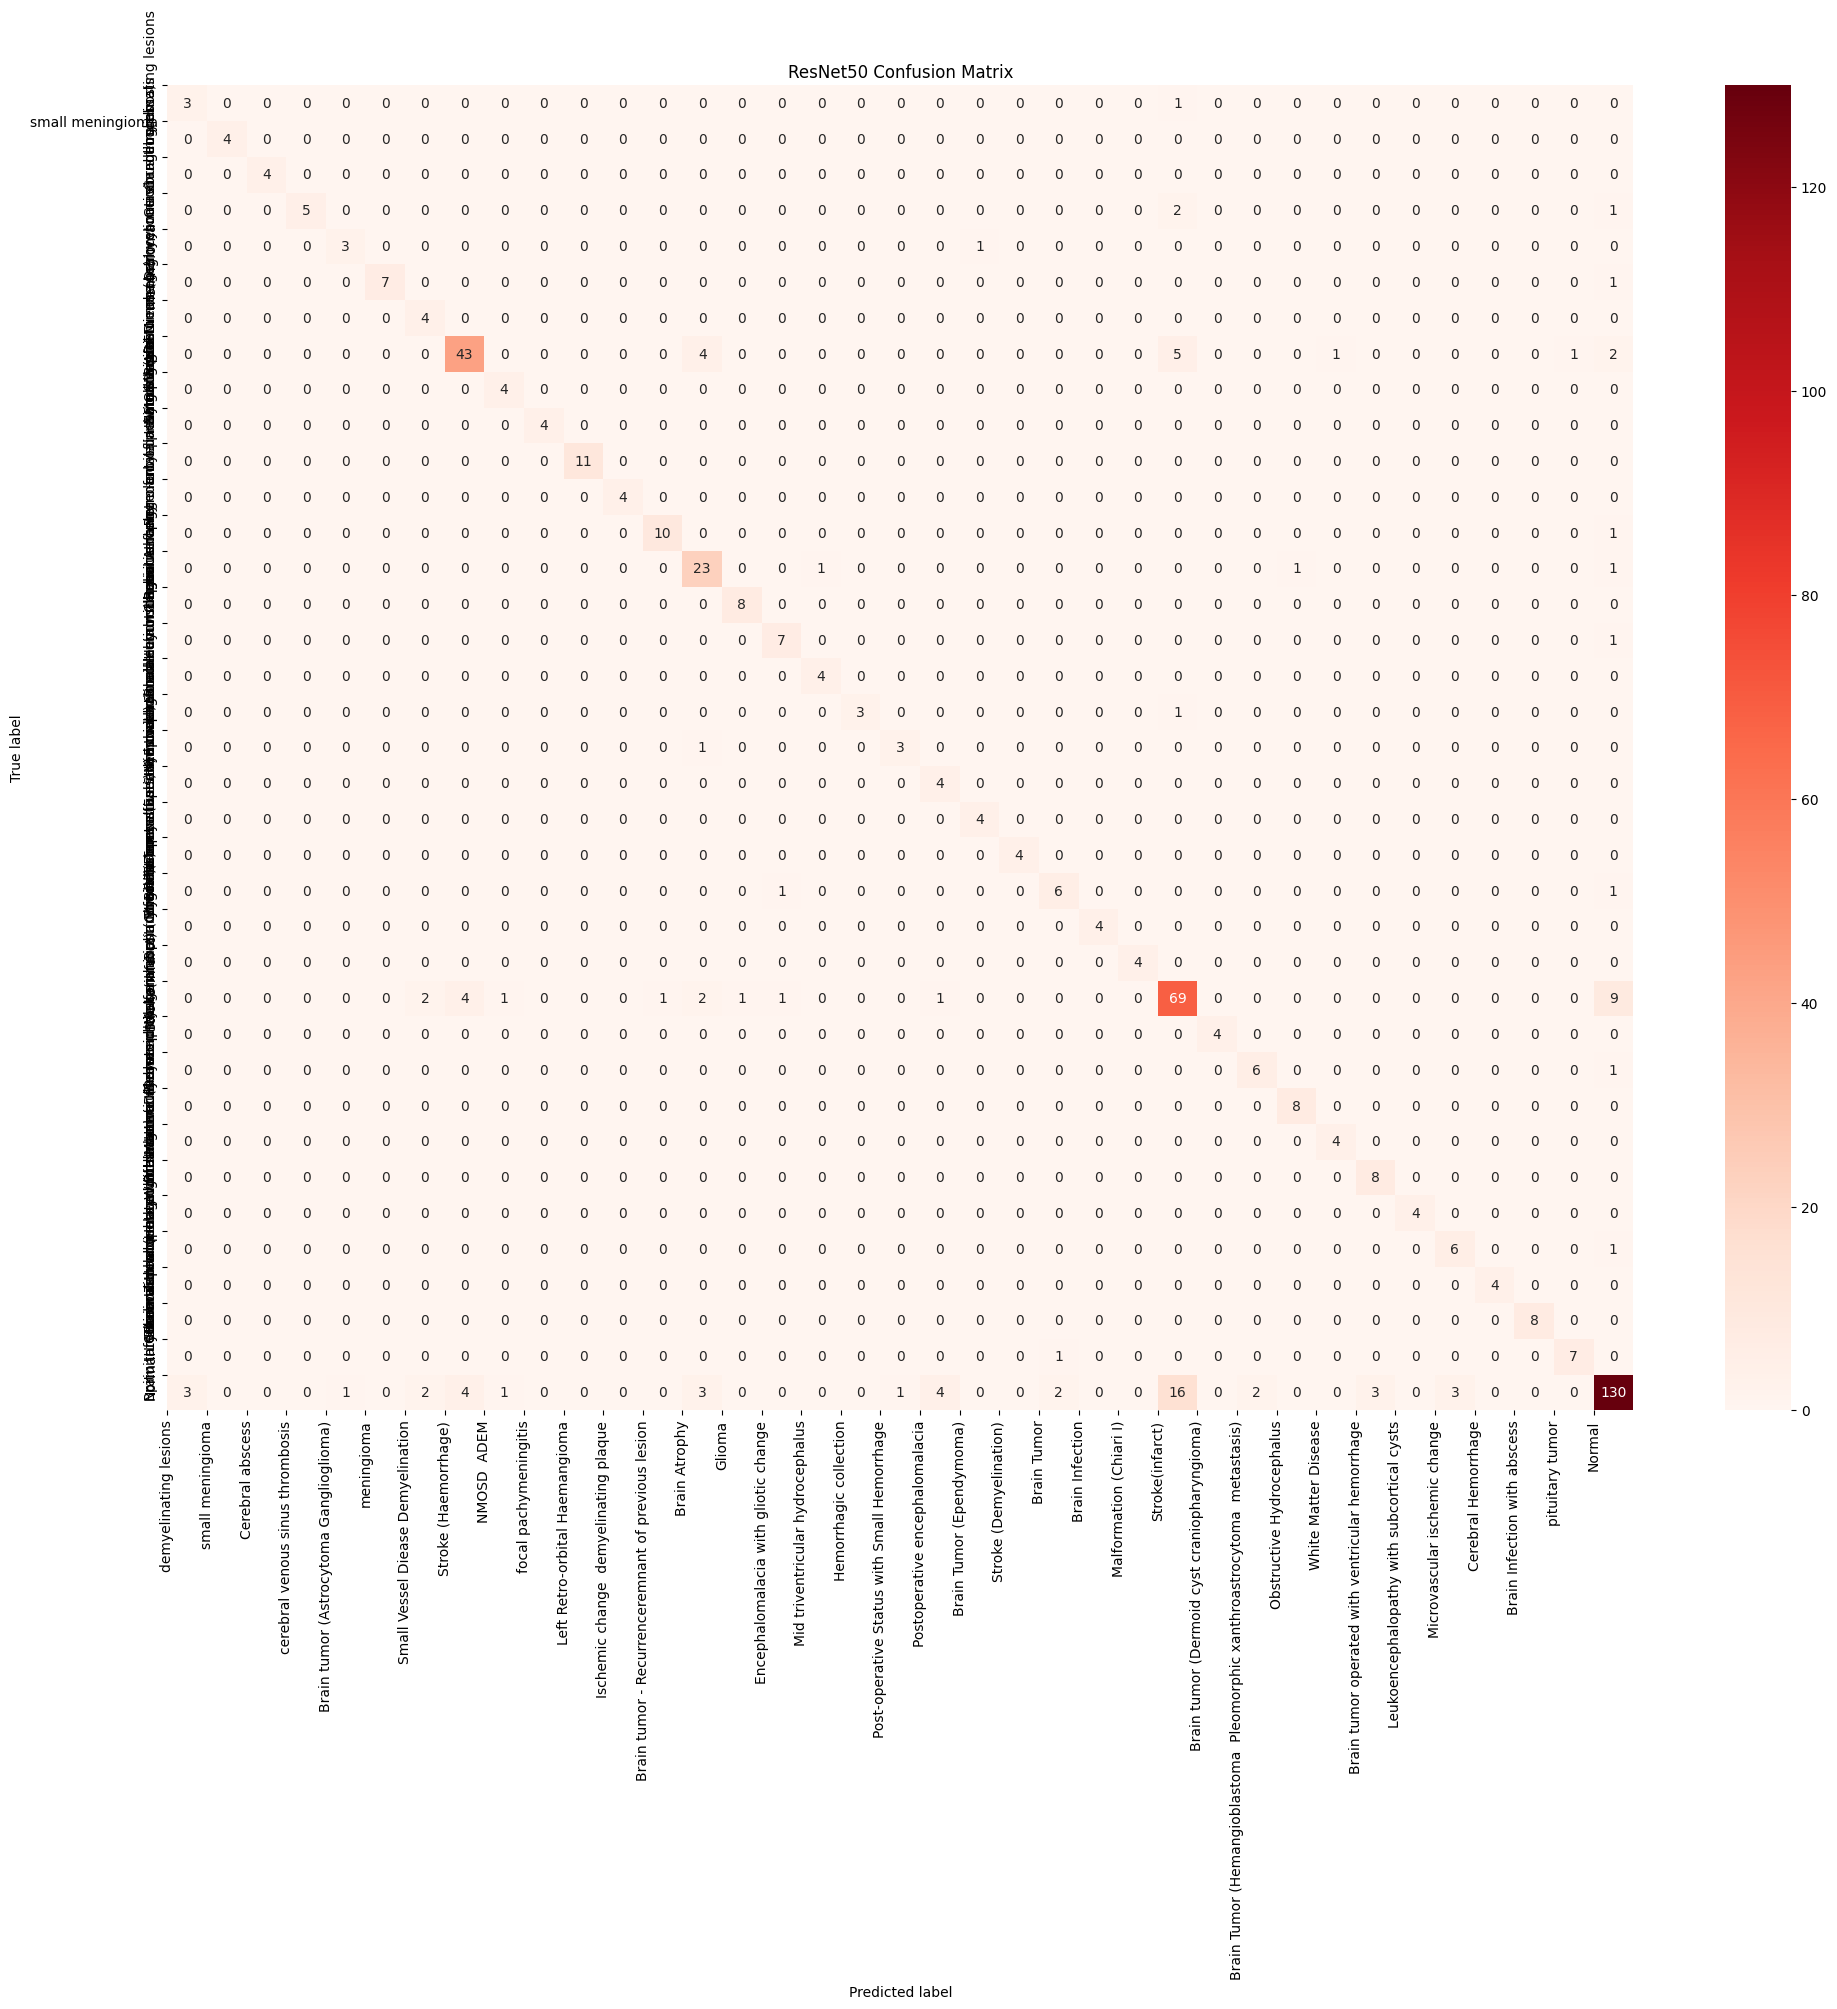

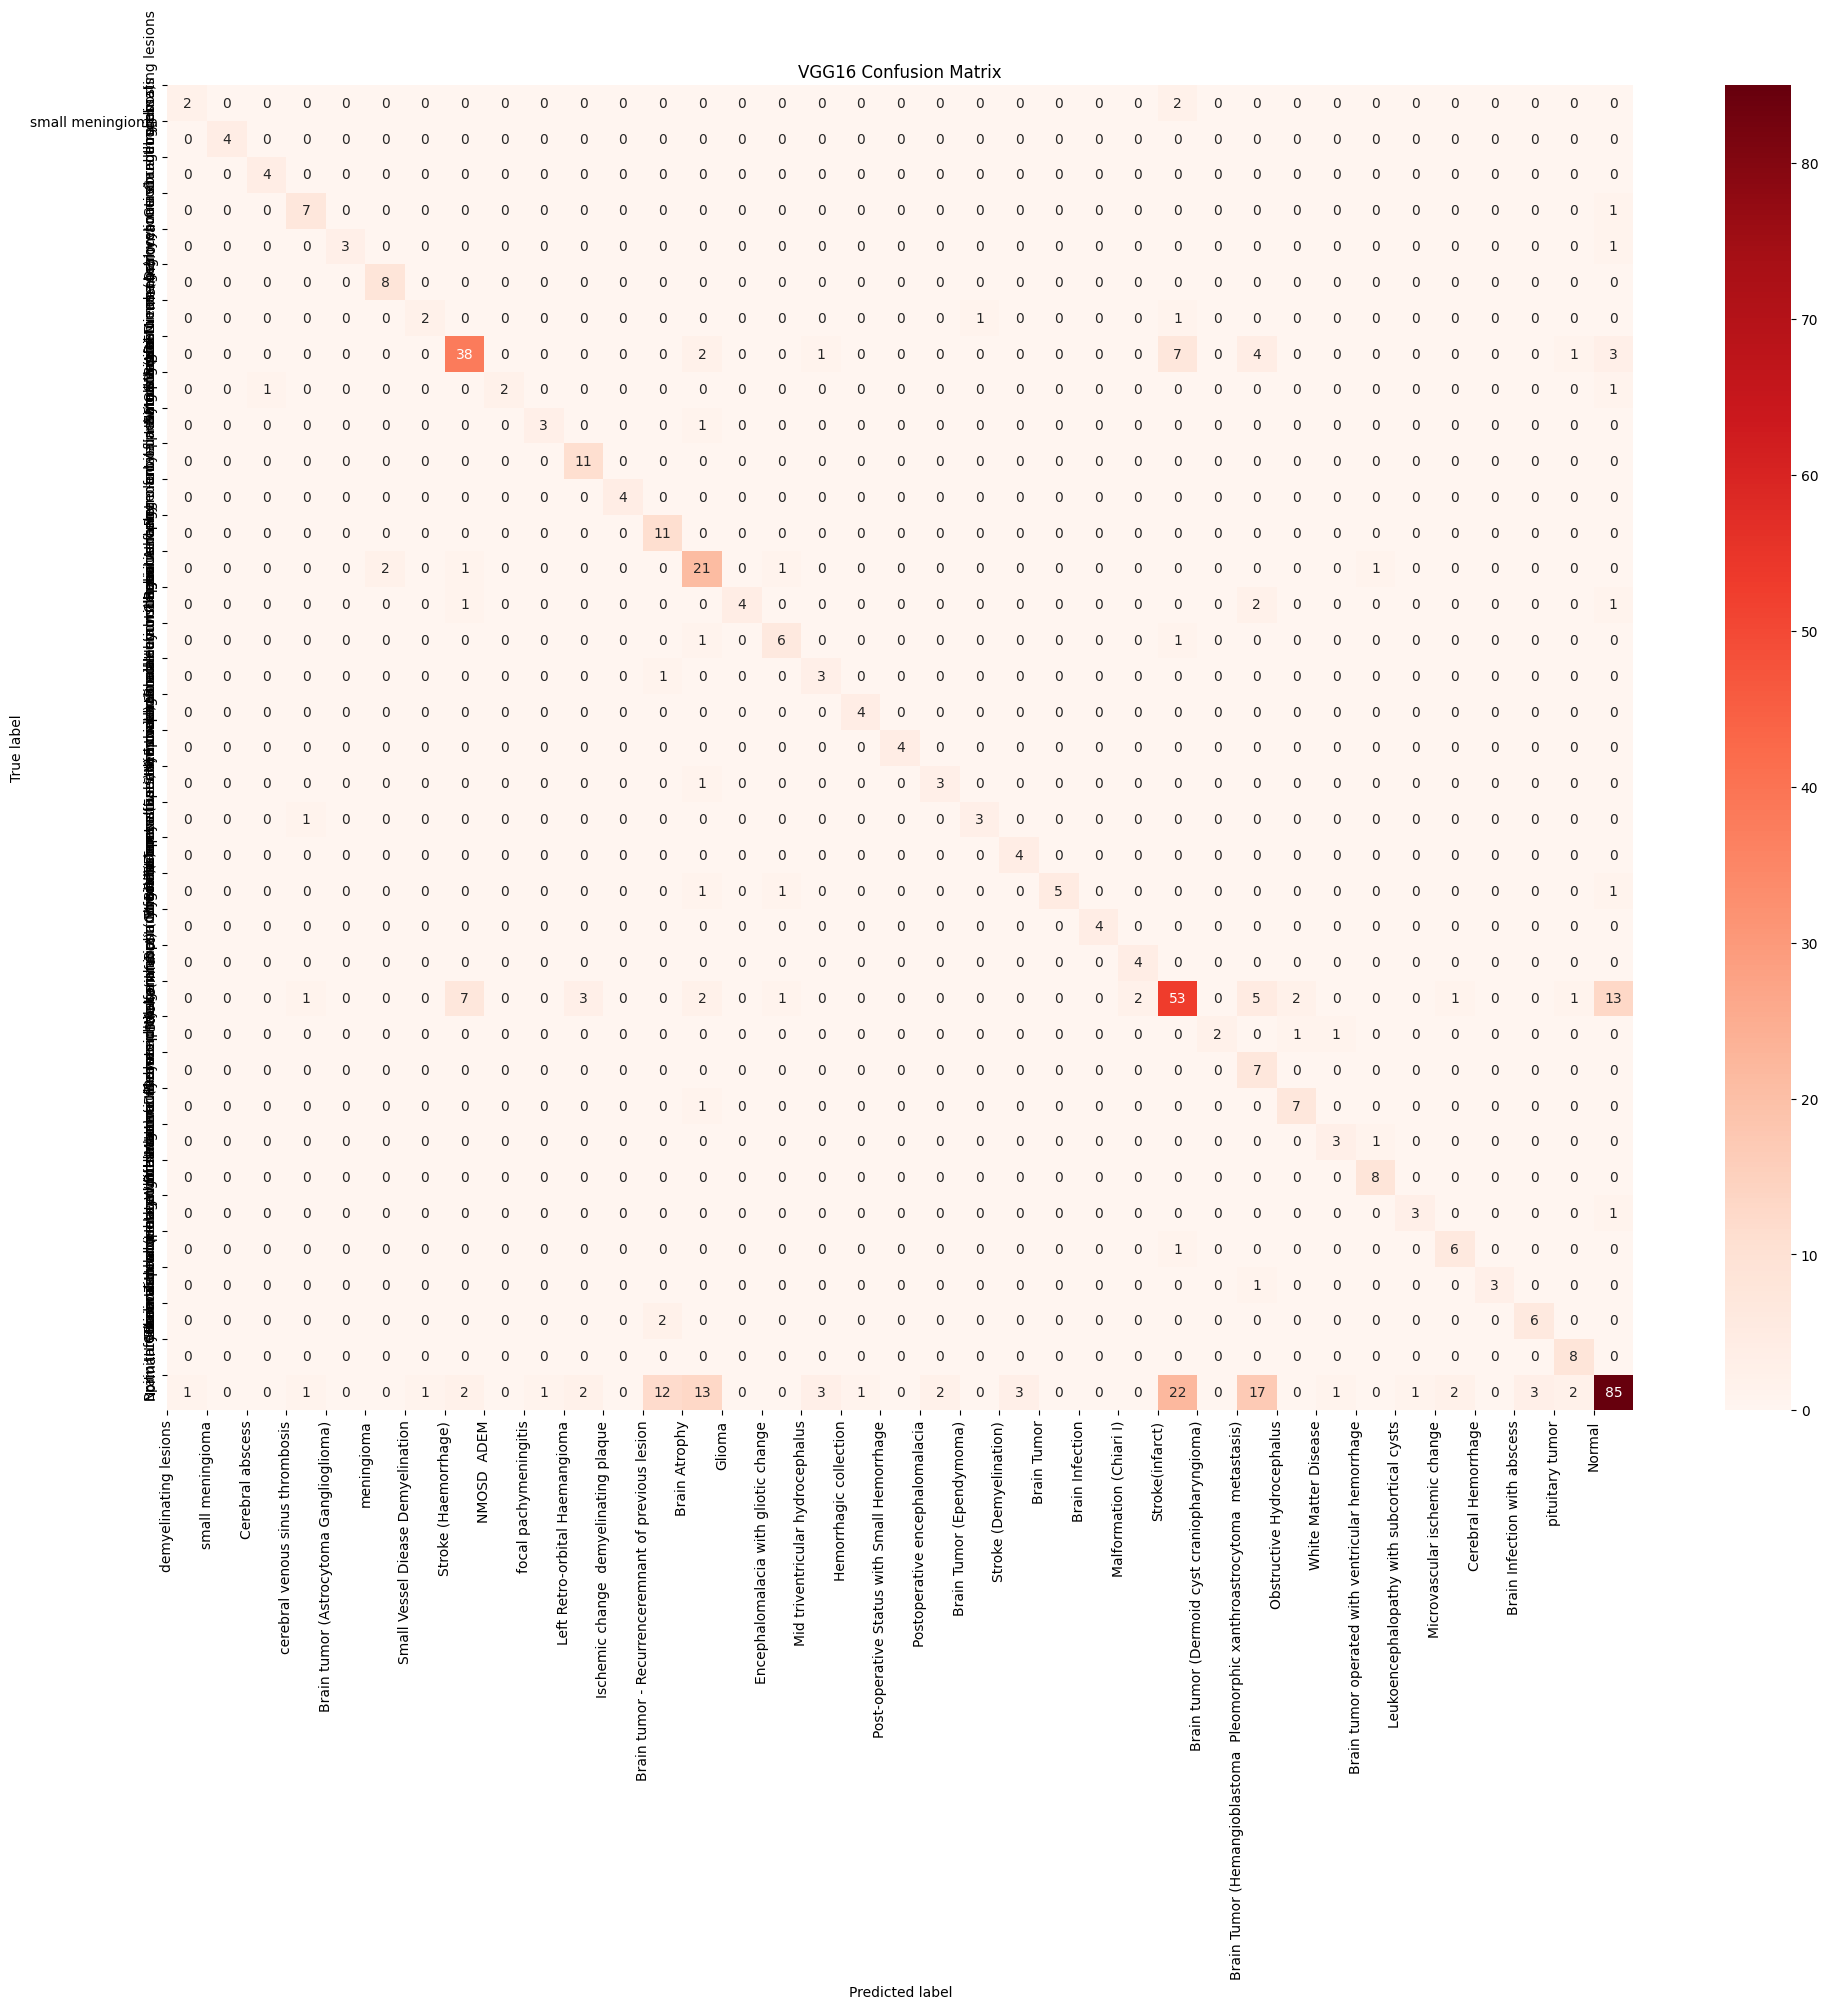

In [41]:
# Define a function to plot the confusion matrix
def plot_confusion_matrix(cm, classes, model_name):
    plt.figure(figsize=(20, 20))
    sns.heatmap(cm, annot=True, cmap='Reds', fmt='d', xticklabels=labels, yticklabels=labels)
    plt.title(f'{model_name} Confusion Matrix')
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# Get predictions for ResNet50
resnet_model.eval()
y_pred = []
y_true = []
for images, labels in data_loaders['val']:
    images = images.to(device)
    labels = labels.to(device)
    outputs = resnet_model(images)
    _, preds = torch.max(outputs, 1)
    y_pred.extend(preds.cpu().numpy())
    y_true.extend(labels.cpu().numpy())

# Calculate confusion matrix for ResNet50
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix for ResNet50
classes = [classes[i] for i in range(len(classes))]
plot_confusion_matrix(cm, classes, 'ResNet50')

# Get predictions for VGG16
vgg_model.eval()
y_pred = []
y_true = []
for images, labels in data_loaders['val']:
    images = images.to(device)
    labels = labels.to(device)
    outputs = vgg_model(images)
    _, preds = torch.max(outputs, 1)
    y_pred.extend(preds.cpu().numpy())
    y_true.extend(labels.cpu().numpy())

# Calculate confusion matrix for VGG16
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix for VGG16
classes = [classes[i] for i in range(len(classes))]
plot_confusion_matrix(cm, classes, 'VGG16')


# 9) Evaluate on Test Split: 10

Calculate the accuracy of each model on test data and also plot confusion matrix for both of them.

Accuracy of the network on the 109 test images: 81.73431734317343 %


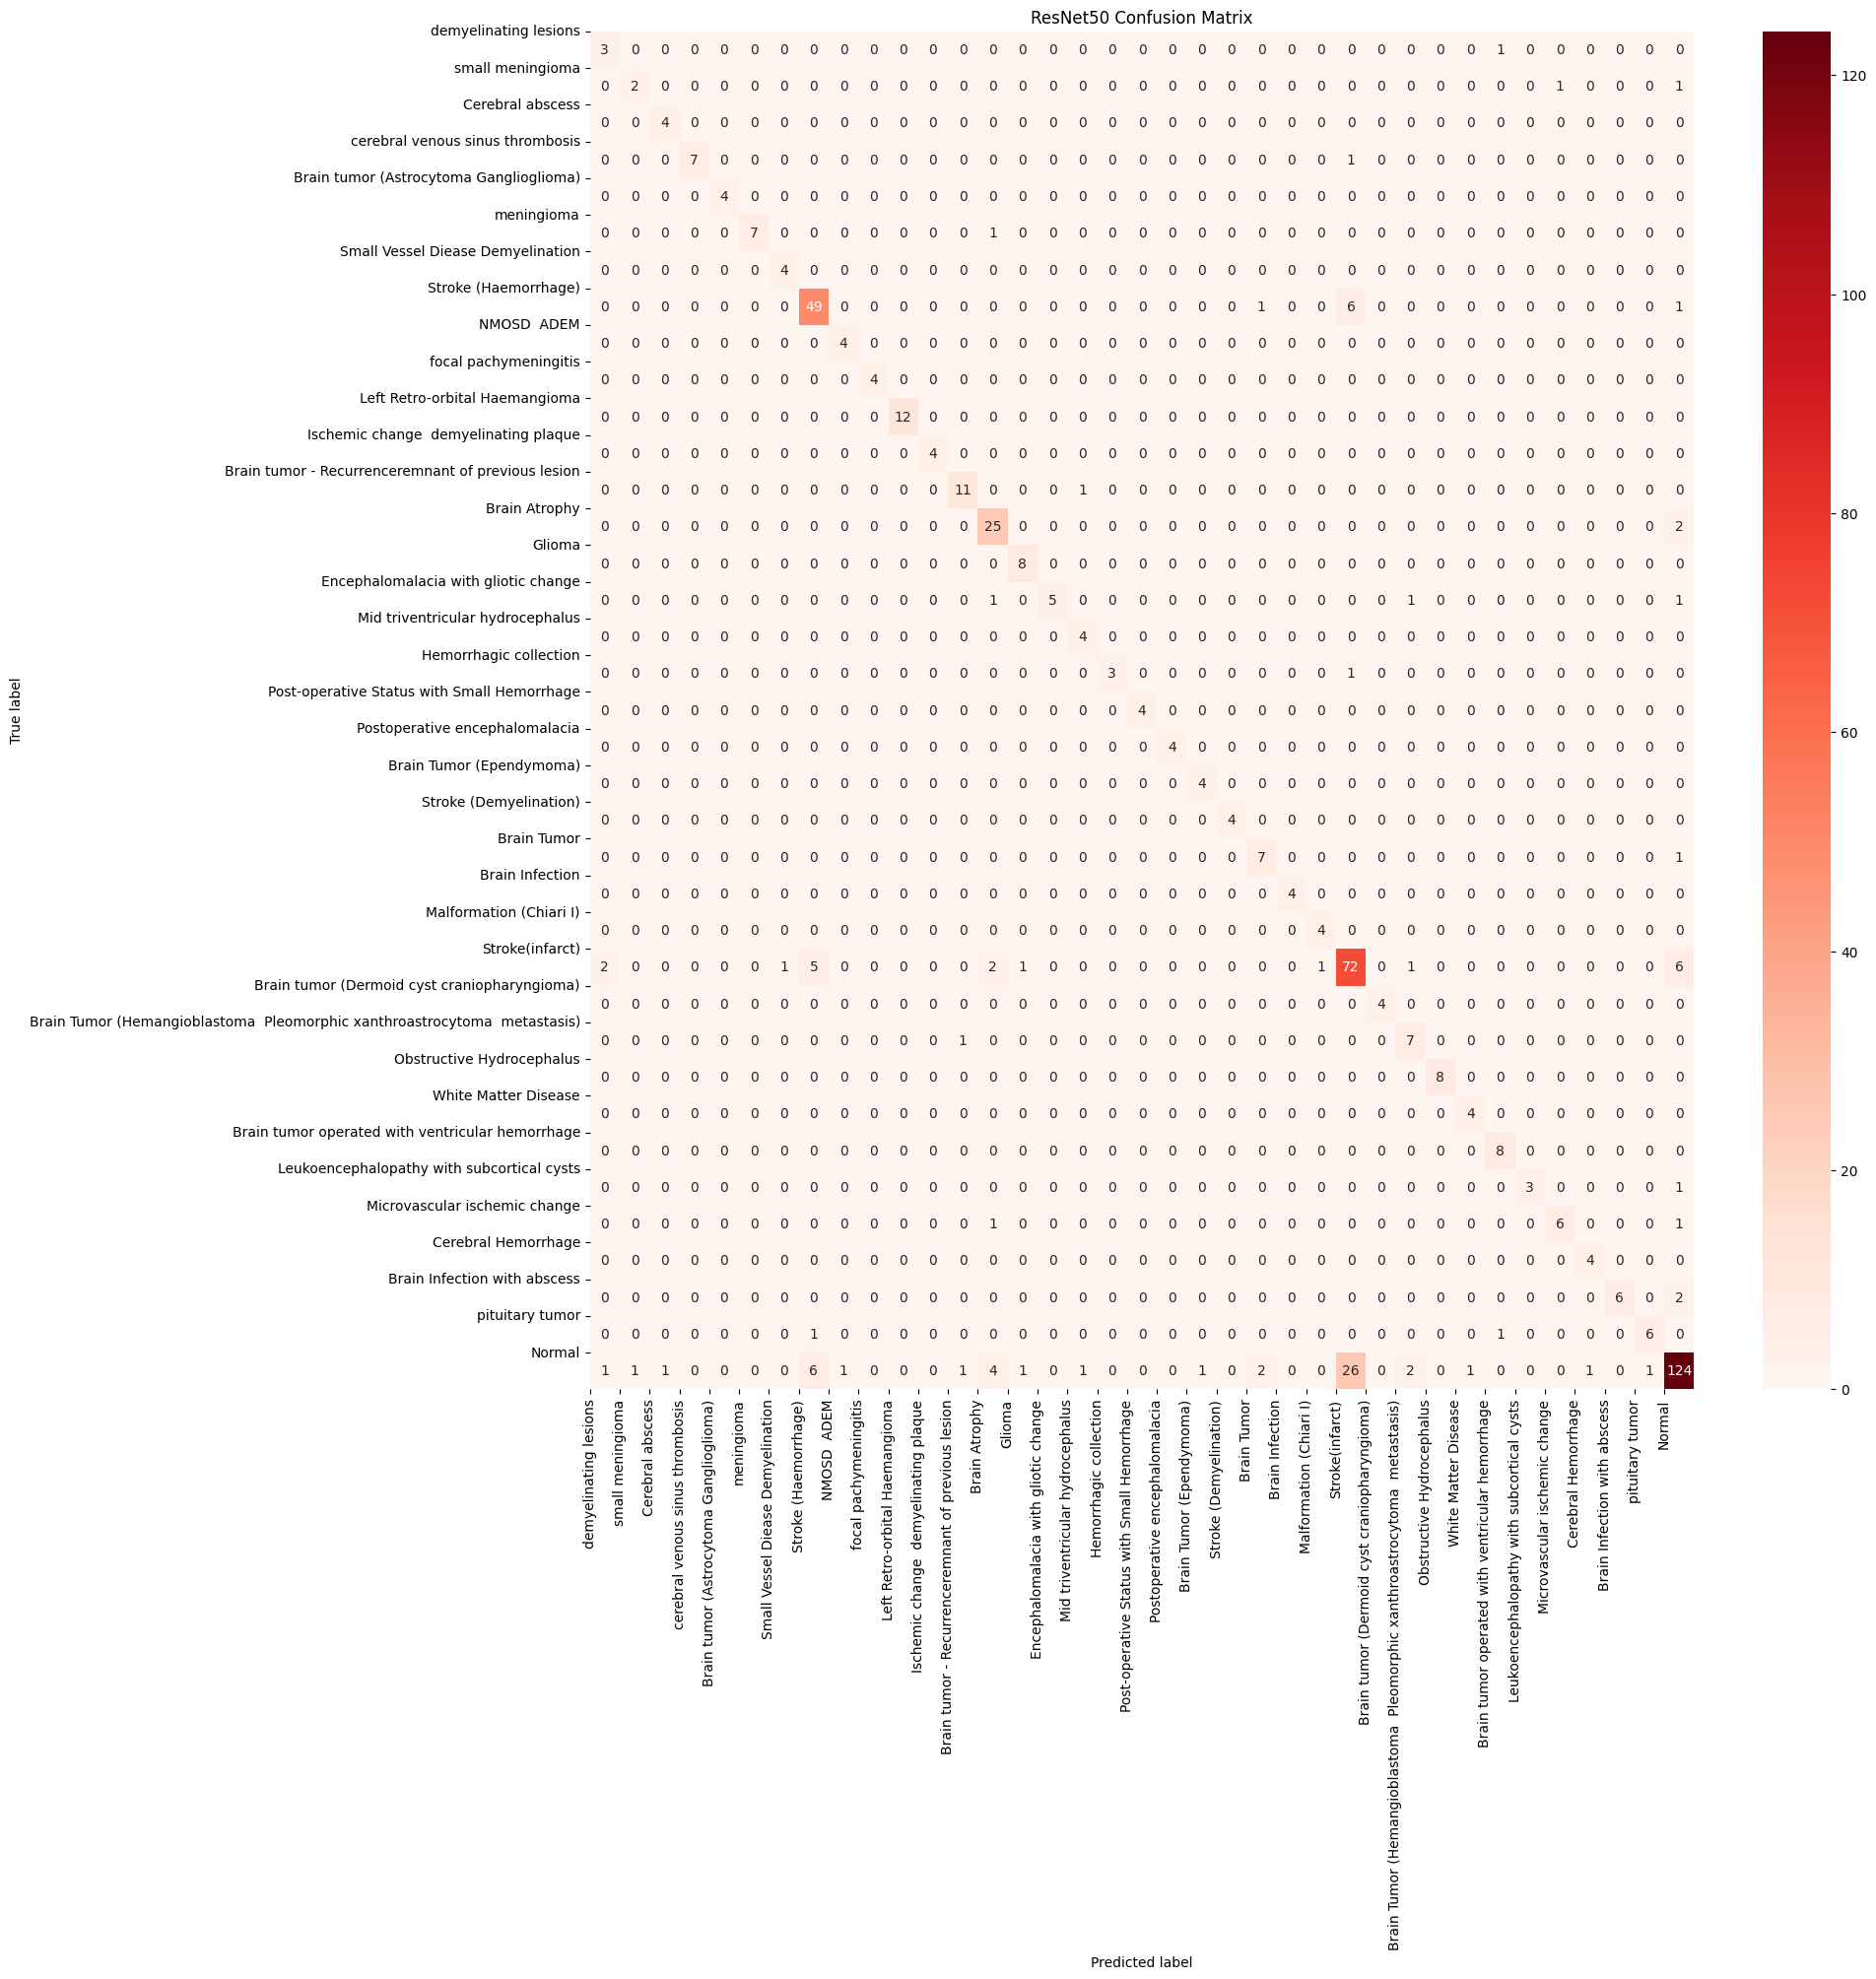

In [45]:
with torch.no_grad():
    correct = 0
    total = 0
    y_pred = []
    y_true = []
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = resnet_model(images)
        _, predicted = torch.max(outputs.data, 1)
        y_pred.extend(predicted.cpu().numpy())
        y_true.extend(labels.cpu().numpy())
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the {} test images: {} %'.format(len(test_loader), 100 * correct / total))
    cm = confusion_matrix(y_true, y_pred)
    plot_confusion_matrix(cm, classes, 'ResNet50')

Accuracy of the network on the 109 test images: 63.284132841328415 %


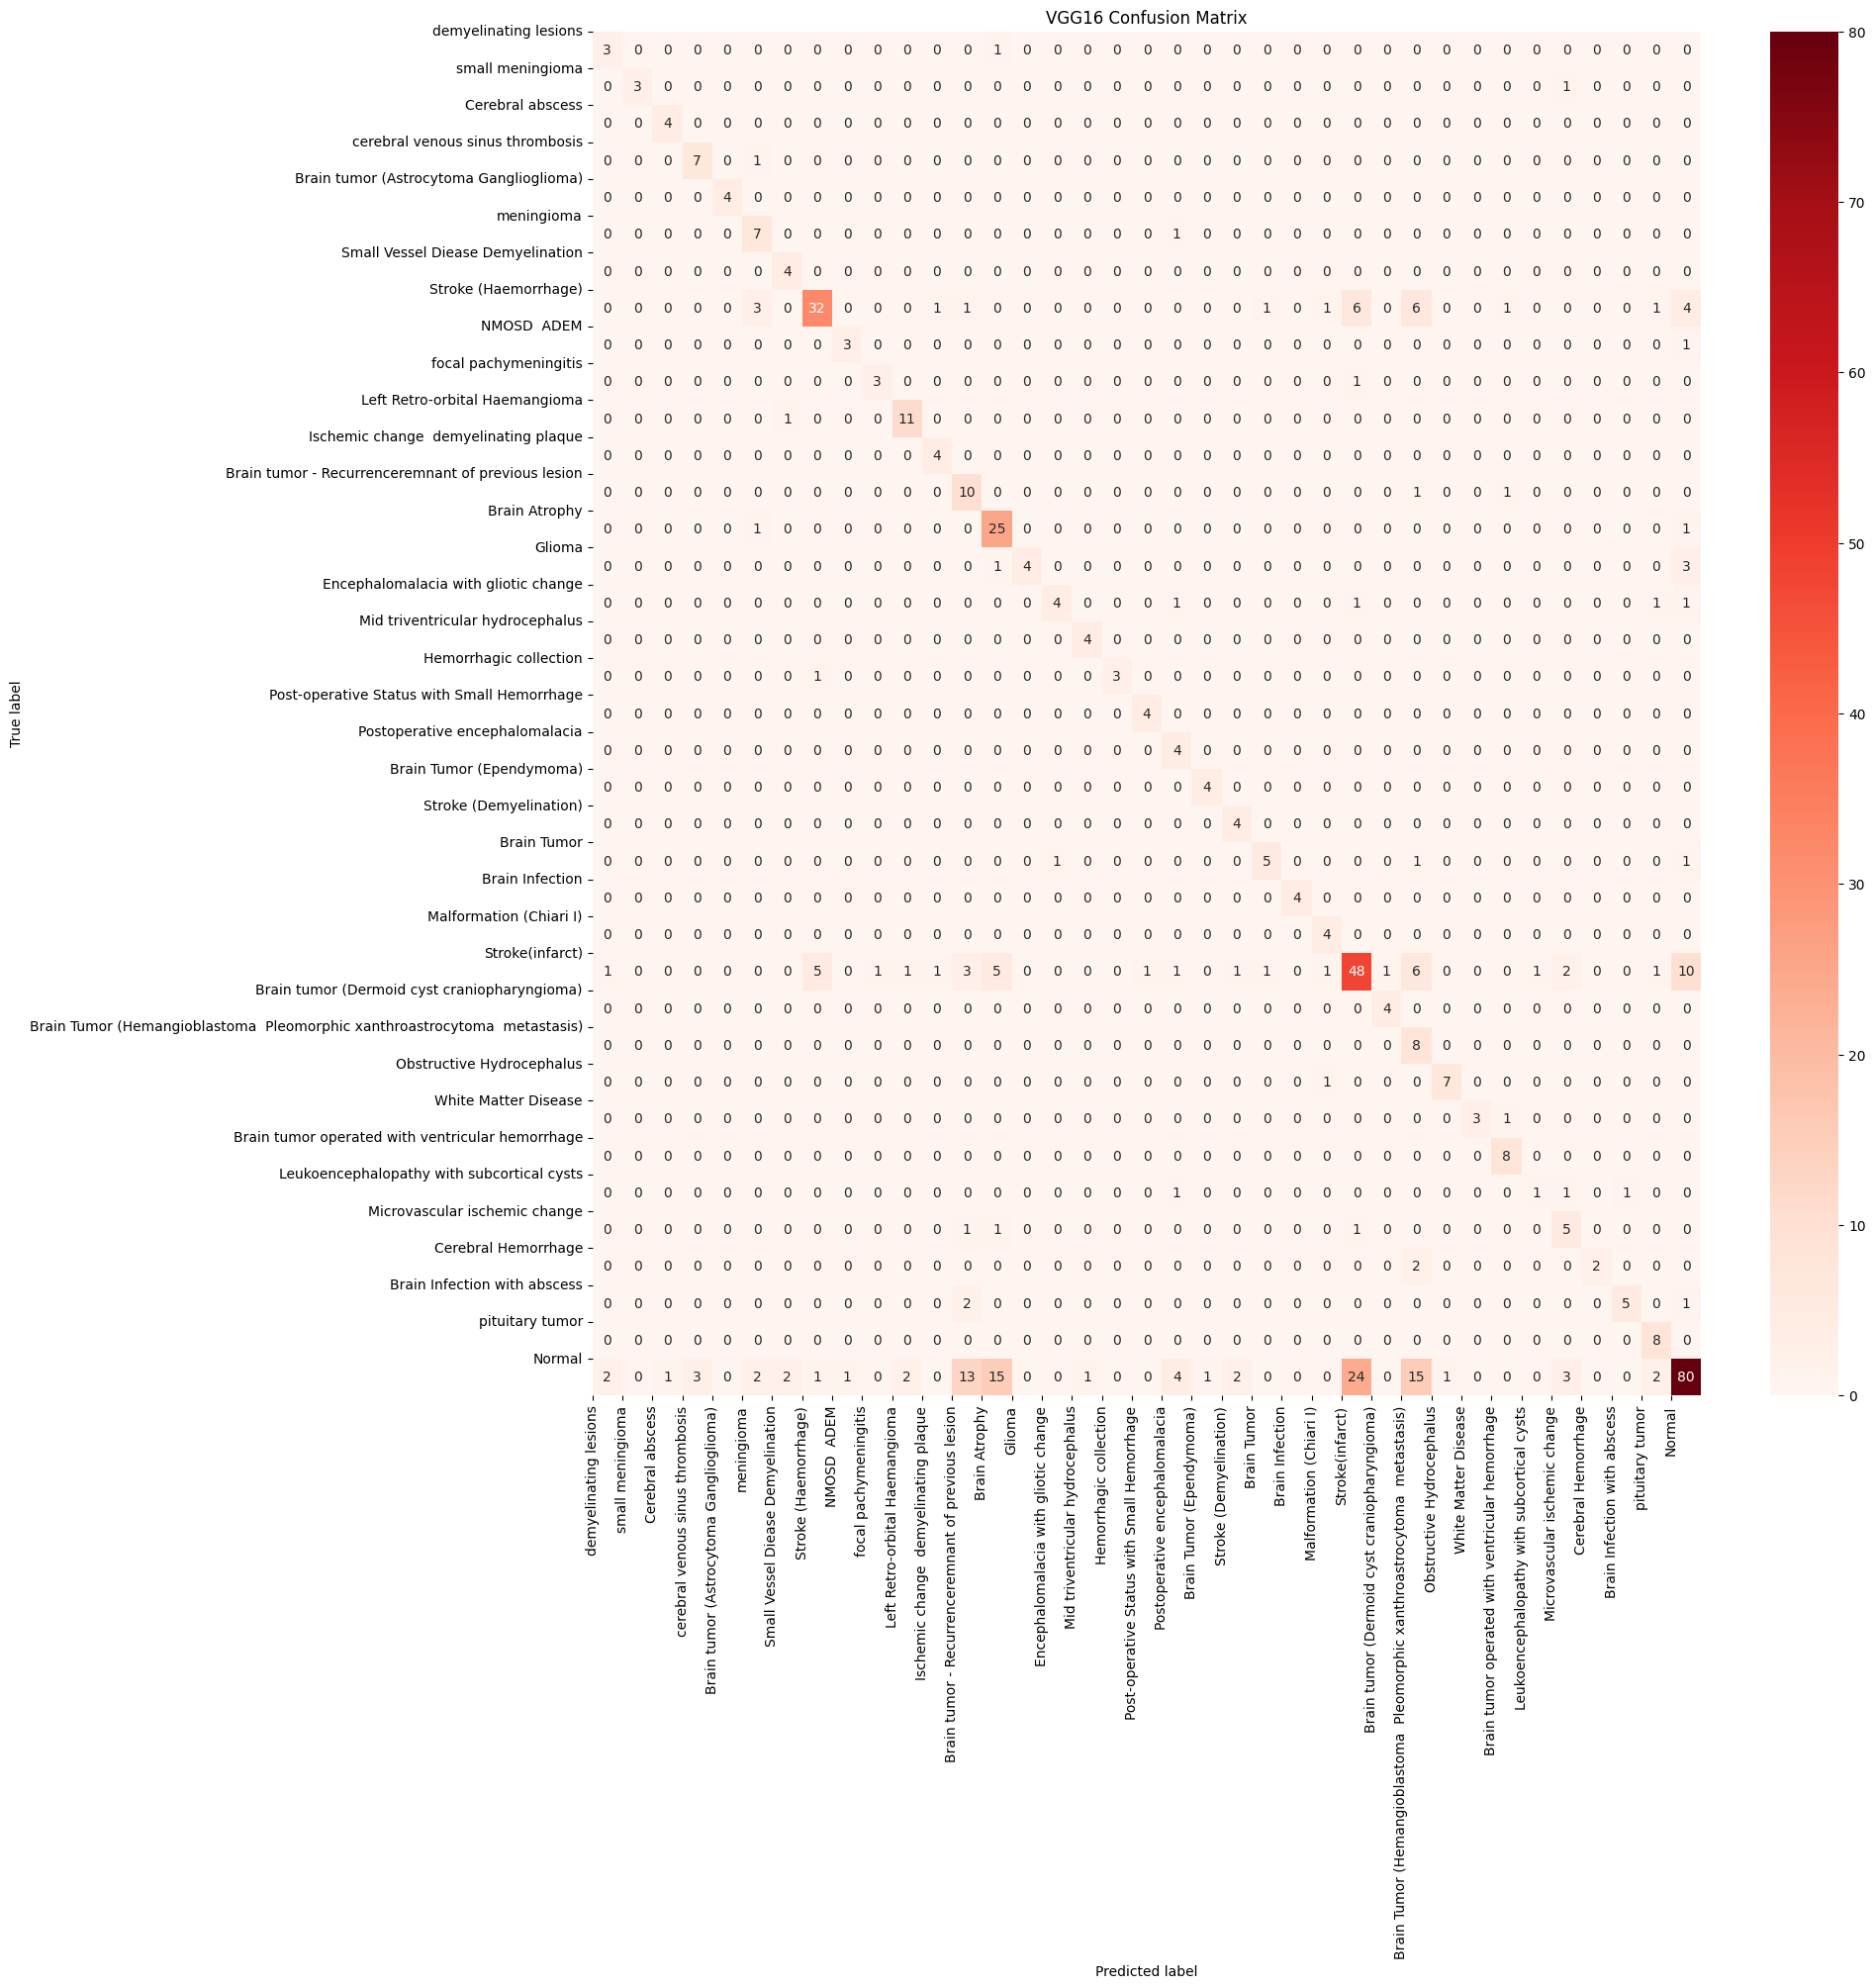

In [46]:
with torch.no_grad():
    correct = 0
    total = 0
    y_pred = []
    y_true = []
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = vgg_model(images)
        _, predicted = torch.max(outputs.data, 1)
        y_pred.extend(predicted.cpu().numpy())
        y_true.extend(labels.cpu().numpy())
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the {} test images: {} %'.format(len(test_loader), 100 * correct / total))
    cm = confusion_matrix(y_true, y_pred)
    plot_confusion_matrix(cm, classes, 'VGG16')